# Tutorial  \# 3 Monte Carlo-ing or Parametric Bootstrap-ing statistics #



We saw in lecture that the sample mean of a sample drawn from a normal distribution is normally distributed with a variance of $\sigma^2/n$.  For other statistics and other distributions it is not usually possible to analytically derive the distribution of the statistic.  When analytic methods fail one can resort to simulation samples and finding the distribution of the statistic my Monte Carlo.  This is also called parametric bootstrap. The idea is to estimate the expectation value of some statistic as $f(\{x\})$ with
\begin{align}
E[f] \simeq E_{\rm boot}[f] \equiv \frac{1}{N_{\rm boot}} \sum_i^{N_{\rm boot} } f\left( \{ x  \}_i  \right)
\end{align}
where the $\{ x \}_i$ is the $i$th simulated data set.  This can be used to find the bias and variance of any statistic as long as you can generate random samples from the distribution.  Th variance will be
\begin{align}
Var_{\rm boot}[f] &= \frac{1}{(N_{\rm boot}-1) }  \sum_i^{N_{\rm boot} } 
\left( ~ f\left( \{ x  \}_i  \right)  -  E_{\rm boot}[f] ~ \right)^2 \\
&= \frac{1}{(N_{\rm boot}-1) }  \sum_i^{N_{\rm boot} } 
\left[~  f\left( \{ x  \}_i  \right)  ~\right]^2  - \frac{N_{\rm boot}}{(N_{\rm boot}-1) }  E_{\rm boot}[f]^2
\end{align}


Gaussian case:
First we will investigate the mean and median of a sample drawn from a Gaussian distribution.  In this case we have a library function that will generate deviates from a normal distribution.

In [26]:
# 1) Consider a data set of $n=10$  drawn from a $\mathcal{N}(0,1)$ distribution.  
# Create a random data set and find the mean and median of that data set.

import numpy as np
import matplotlib.pyplot as plt

x = np.random.normal(0,1,100)

print 'mean = ',np.mean(x)
print 'median = ',np.median(x)


mean =  0.04775240440756492
median =  -0.03687930587836928


In [251]:
#2) Find the bias and variance of the sample mean and median by simulating 
#  $N_{\rm boot}=1,000$ data sets.

Nboot = 1000
Nsample = 10
means = np.empty(Nboot)
medians = np.empty(Nboot)
for i in range(Nboot) :
    
    x = np.random.normal(0,1,Nsample)

    means[i] = np.mean(x)
    medians[i] = np.median(x)
    
print 'Var of means ',np.var(means)
print 'Var of medians ',np.var(medians)


# What is the prediction of theory for the variance of the maen?
#. Does it agree with theory?

print 1./Nsample

#Is the variance of the median larger or smaller than the mean?
#larger

Var of means  0.10372091767169474
Var of medians  0.14049490458652275
0.1


We are now going to look at a more realistic example where the bias and variance of the statistic, in this case an estimator, is not known analytically.  The Schechter luminosity function is used to model the distribution of galaxy luminosities.  It is given by
\begin{align}
n(L) = \phi_* \left( \frac{L}{L_*}\right)^\alpha e^{-L/L_*} \frac{dL}{L_*}
\end{align}
This has three parameters, $ \phi_*$, $\alpha$ and $L_*$.  We will be interested measuring the value of $L_*$ with a fixed value of $\alpha = -1.25$.  The normalization $ \phi_*$ will not be relevant.  An estimator for $L_*$ is 
\begin{align}
\hat{L}_* = \left(- \frac{\alpha}{(1+\alpha) n}  \sum_{i=1}^n L_i  \right)
\end{align}
where $L_i$ are the luminosities of each observed galaxy and $n$ is the number of galaxies in the data set.  We want to know if this estimator is biased and what its variance is.


In this case we do not have a library function to get random deviates from this distribution so we will have to build one ourselves.

3) Make a function that takes the luminosity $ x = L/L_*$ and returns the properly normalized pdf for galaxy luminosities.  Take the minimum luminosity to be $x_{min} = 0.1$.
You will find the following integral useful
\begin{align}
\Gamma(\alpha+1 ,x_{\rm min},x_{\rm max} ) =\int^{x_{\rm max}}_{x_{\rm min}} dx ~x^\alpha e^{-x}
\end{align}
where $\Gamma(\alpha+1 ,x_{\rm min},x_{\rm max} ) $ is the incomplete gamma function.  This can be calculated using mpmath.gammainc(z,a,b) (the scipy version does not work for z < 0!)


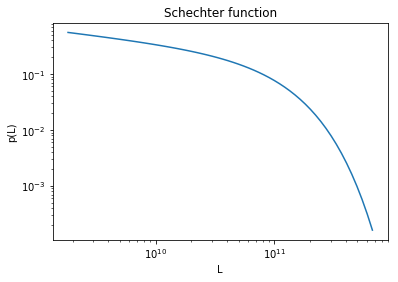

In [260]:
Lstar = 1.0e11
alpha = -1.25
#alpha = 1.01
xmin = 0.03

import mpmath

# hint: use mpmath.gammainc(alpha + 1,a,b)

def schechter(x) :
    return x**(alpha)*np.exp(-x)/mpmath.gammainc(alpha+1,xmin)

schechterV = np.vectorize(schechter)  ## vectorize the function so that it will take a vector

# Make a plot of the pdf.  To make it look good you will probably need to 
# use plt.x(y)scale('log') to plot it in log scale. Label the axis.

lnx = np.arange(-4,2,0.1) # evenly spaced in log
x = np.exp(lnx)

p = schechterV(x)*x
L = x*Lstar

plt.plot(L,p)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('p(L)')
plt.xlabel('L')
plt.title('Schechter function')
plt.show()

0.0409954920965162


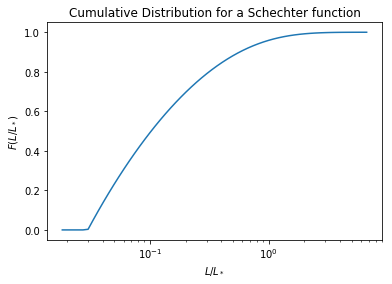

In [261]:
#4) Make a function that returns the cumulative distribution for L/Lstar.  
# Call it F. Plot it.


def F(xx) :
    if(xx < xmin) :
        return 0.0
    return mpmath.gammainc(1+alpha,xmin,xx)/mpmath.gammainc(1+alpha,xmin)

FV = np.vectorize(F)

print 1-F(1)
## plot the cumulative distribution using the same vector x above.
## It should go from 0 to 1. Put some labels on it.

f = FV(x)
plt.plot(x,f)

plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$L / L_*$')
plt.ylabel(r'$F(L/L_*)$')
plt.title('Cumulative Distribution for a Schechter function')

plt.show()

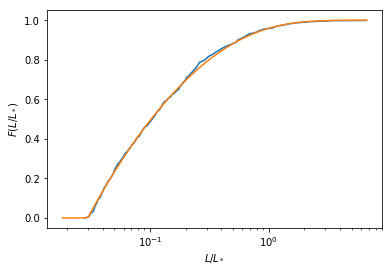

In [262]:
## Now we can invert the cumulative numerically using the interpolation function
def quantile(u) :
    return np.interp(u,f,np.log(x))

## Now we can draw randomly from the schechter distribution by passing 
## uniform random numbers into the quantile function.
## Here are 1000 luminosities takens from the distribution.
u = np.random.uniform(0,1,1000)
lnx = quantile(u)

# We can varify this by making the imperical cumulative distribution 
# and comparing it to the cumulative distribution above.
lnx = np.sort(lnx)
y = np.arange(0.0,len(lnx),1)/len(lnx)

plt.plot(np.exp(lnx),y)
plt.xscale('log')


plt.plot(x,f)
plt.xscale('log')
plt.xlabel(r'$L/L_*$')
plt.ylabel(r'$F(L/L_*)$')

plt.show()

In [263]:
# 5) Now that we have a way of generating random luminosities we can
#   find the bias and variance of the estimator for L* given above.
#   Do 10000 random data sets of 20 galaxies each and find the bias and 
#   variance.

Nboot = 10000
Nsample = 200

#q = np.array([F(1.0)])
#def estimator(xx) :
#    y = np.sort(xx)
#    return y[ int( (len(y)-1)*q +0.5)  ]

Lstar_estimates = np.empty(Nboot)
for i in range(Nboot) :
    
    u = np.random.uniform(0,1,Nsample)
    lnx = quantile(u)
    L = np.exp(lnx)
    
    Lstar_estimates[i] = ( alpha*np.mean(L)/(alpha + 1) )

    #Lstar_estimates[i] = estimator(L)

print 'means Lstar',np.mean(Lstar_estimates)
print 'bias',np.mean(Lstar_estimates) - 1
print 'standard deviation Lstar ',np.std(Lstar_estimates)


means Lstar 1.1792326692823654
bias 0.17923266928236536
standard deviation Lstar  0.1286957421401132


In [ ]:
# 6) If you lower the minimum luminosity from 0.1 L_* to 0.05 L_* does the bias change ?




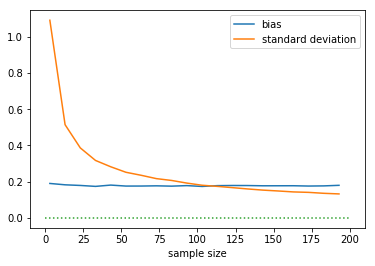

In [264]:
# 7) If you increase the sample size with L_min = 0.1 L* does the bias get smaller?  
# Make a plot of the bias as a function of the smaple size from 3 to 200.

Nboot = 10000

samples = range(3,200,10)
Lstar_estimates = np.empty(Nboot)
biases = np.empty(len(samples))
stds =  np.empty(len(samples))
j = 0
for Nsample in samples :

    for i in range(Nboot) :
    
        u = np.random.uniform(0,1,Nsample)
        lnx = quantile(u)
        L = np.exp(lnx)
    
        Lstar_estimates[i] = ( alpha*np.mean(L)/(alpha + 1) )
        #Lstar_estimates[i] = estimator(L)
    
    #print 'means Lstar',np.mean(Lstar_estimates)
    #print 'standard deviation Lstar ',np.std(Lstar_estimates)
    
    biases[j] = np.mean(Lstar_estimates) - 1
    stds[j] = np.std(Lstar_estimates)
    j += 1

plt.plot(samples,biases,label='bias')
plt.plot(samples,stds,label='standard deviation')
plt.plot([0,200],[0,0],linestyle=':')
plt.legend()
plt.xlabel('sample size')
plt.show()
